In [16]:
# default_exp model.base

In [17]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [18]:
# hide
from nbdev.showdoc import *

# M5 Base Model

In [19]:
# export
from fastseq.core import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastai2.torch_basics import *
from fastai2.callback.all import *

In [20]:
path = Path('../data/m5_tiny/rows')

{'Train': 10366, 'Val': 6035, 'Validation': 2059, 'Evaluation': 2059}


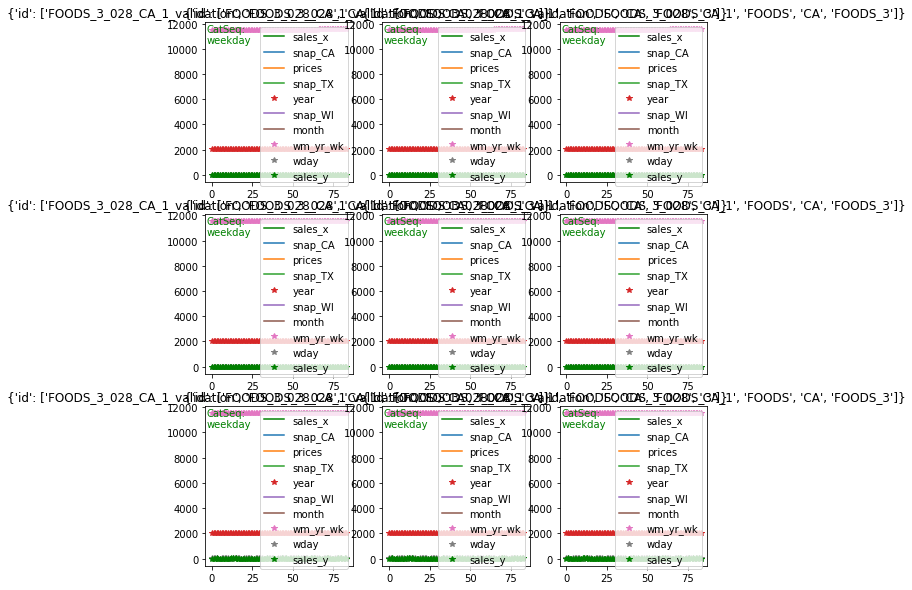

In [21]:
lookback, horizon = 28*2, 28
dl =  MTSDataLoaders.from_m5_path(path, 'sales', horizon = horizon, lookback = lookback,
                                  train_start = 1600,
                                 )
dl.show_batch()

In [22]:
%%time
for o in dl.train:
    pass

CPU times: user 823 ms, sys: 406 ms, total: 1.23 s
Wall time: 2.61 s


In [23]:
for o in dl.train:
    o._dict()
    break

In [24]:
o[-1].mean(),o[-1].std(),o[0].mean(),o[0].std()

(TensorSeq(-0.0369, device='cuda:0'),
 TensorSeq(0.9736, device='cuda:0'),
 TensorSeq(-4.0845e-08, device='cuda:0'),
 TensorSeq(0.9912, device='cuda:0'))

In [25]:
# export
class SeqTab(Module):
    """Basic model for sequential data."""
    def __init__(self, n_cont, out_sz, layers, y_range=None,):
        ps = [0]*len(layers)
        sizes = [n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=True and (i!=len(actns)-1), p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps+[0.],actns))]
        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.layers = nn.Sequential(*_layers)

    def forward(self, x, ts_con, ts_cat, cat, con):
        x_bn = self.bn_cont(x[:,0])
        o = [x, self.layers(x_bn)[:,None,:]]
        return torch.cat(o,-1)

In [26]:
lookback, horizon = 28*2, 28
mdl = SeqTab(lookback,horizon,[200])
shape = list(mdl(torch.randn(16,1,lookback),[],[],[],[]).shape)
test_eq(shape,(16,1,lookback+horizon))
print(shape)

[16, 1, 84]


In [27]:
#export
@delegates(Learner.__init__)
def SeqTabLearner(dls, layers=None, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `SeqTab` created using the remaining params."
    if layers is None: layers = [200,100]    
    model = SeqTab(dls.train.lookback, dls.train.horizon, layers)
    return Learner(dls, model, loss_func = F.mse_loss, opt_func= ranger,**kwargs)

In [28]:
learn = SeqTabLearner(dl)

(2.5118865210060903e-08, 0.013182567432522774)

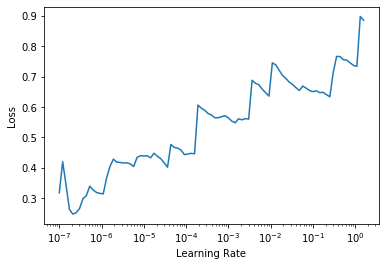

In [29]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.536483,0.568313,00:04
1,0.536471,0.568293,00:04
2,0.536458,0.568273,00:04


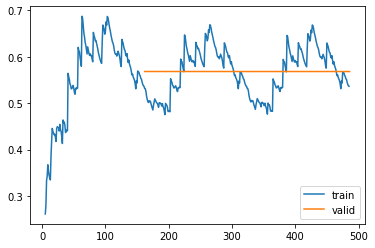

In [32]:
learn.fit(3,1e-7)
learn.recorder.plot_loss()

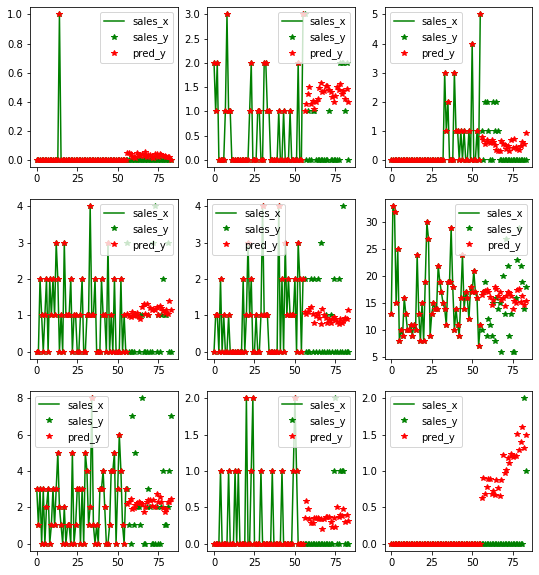

In [33]:
learn.show_results(show_kwargs = dict(extra = False))

In [43]:
pred, target = learn.get_preds(2)
pred.shape, target.shape

(torch.Size([2059, 1, 84]), torch.Size([2059, 1, 84]))

In [76]:
# inputs,preds,targs,decoded,losses
inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
decoded.shape

torch.Size([2059, 1, 84])

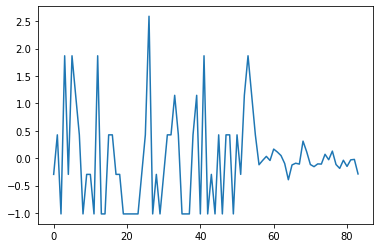

In [91]:
plt.plot(decoded[0,0,:].T)

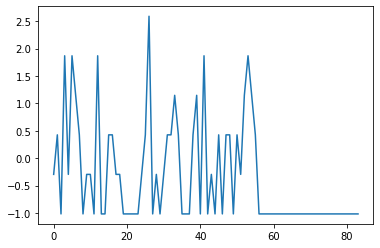

In [90]:
plt.plot(targs[0,0,:].T)

In [64]:
pred[:,0,-28:]

tensor([[-0.1205, -0.0407,  0.0322,  ..., -0.0314, -0.0230, -0.2883],
        [ 0.0080, -0.2734, -0.0272,  ...,  0.1947, -0.0398, -0.2122],
        [ 0.1152,  0.0449,  0.2061,  ...,  0.3176, -0.1358, -0.2776],
        ...,
        [ 0.1597,  0.3500,  0.4765,  ...,  0.2839,  0.3919,  0.2416],
        [ 0.5917,  0.2255,  0.5873,  ...,  0.4769,  0.5637,  0.3325],
        [ 0.3316,  0.2691,  0.3594,  ...,  0.3980,  0.6324,  0.4691]])

In [65]:
target_decode[:,0,-28:]

tensor([[-0.1205, -0.0407,  0.0322,  ..., -0.0314, -0.0230, -0.2883],
        [ 0.0080, -0.2734, -0.0272,  ...,  0.1947, -0.0398, -0.2122],
        [ 0.1152,  0.0449,  0.2061,  ...,  0.3176, -0.1358, -0.2776],
        ...,
        [ 0.1597,  0.3500,  0.4765,  ...,  0.2839,  0.3919,  0.2416],
        [ 0.5917,  0.2255,  0.5873,  ...,  0.4769,  0.5637,  0.3325],
        [ 0.3316,  0.2691,  0.3594,  ...,  0.3980,  0.6324,  0.4691]])

In [34]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 10_model.base.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [149]:
git_add('010_model.base.ipynb', commit_msg='initial model')

Converted 02_data.load.ipynb.


['/home/tako/dev/fastseq/fastseq/data/load.py',
 '/home/tako/dev/fastseq/nbs/02_data.load.ipynb']